# Identifying Cosmic Filaments with Classification



Imagine you are an astrophysicist analyzing a new image of a distant galaxy. You've identified two intertwined cosmic gas filaments, and you want to build a model that can automatically classify which filament a given point in space belongs to.

Input Features (Independent Variables):
- x_coordinate: The x-position of a point in the galactic image.
- y_coordinate: The y-position of a point in the galactic image.

Target Output (Dependent Variable):
- filament_class: A binary label, 0 for the first filament and 1 for the second.

## Set up environment

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.draw_graph import draw_dot
from src.model.builder import build_classification_model
from src.model.training import train_model
from src.model.evaluation import evaluate_model
from src.model.hp_tuning import start_hp_search

import random

random.seed(42)

import numpy as np

np.random.seed(42)

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

import seaborn as sns

sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Hyperparams

In [2]:
TEST_SIZE = 0.1

EPOCHS = 1000

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_DELTA = 1e-3

## Load data

In [3]:
df = pd.read_csv("cosmic_filaments_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,x_coord,y_coord,Spiral_Index
110,0.560123,-1,0
419,-0.133753,2,1
565,-2.694880,-3,1
77,1.181600,0,0
181,-3.055169,0,0


### Separate input from target

In [4]:
targets = df["Spiral_Index"]
inputs = df.drop(["Spiral_Index"], axis=1)

In [5]:
inputs.min()

x_coord   -5.369288
y_coord   -4.000000
dtype: float64

In [6]:
inputs.max()

x_coord    5.275871
y_coord    4.000000
dtype: float64

### Visualize


Displaying 2D plot of the generated spiral data...


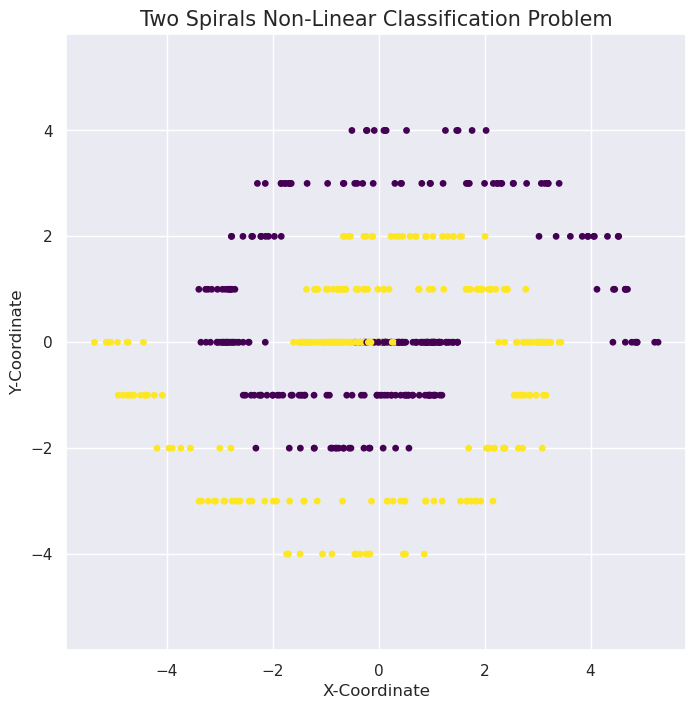

In [7]:
plt.figure(figsize=(8, 8))
plt.title("Two Spirals Non-Linear Classification Problem", fontsize=15)
plt.scatter(inputs["x_coord"], inputs["y_coord"], c=targets, cmap='viridis', s=15) # s is marker size
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")
plt.axis('equal')
print("\nDisplaying 2D plot of the generated spiral data...")
plt.show()

### Feature Engineering

In [8]:
x_coords = inputs["x_coord"]
y_coords = inputs["y_coord"]

# 1. Engineer Polar Coordinates
inputs["radius"] = np.sqrt(x_coords**2 + y_coords**2)
inputs["angle"] = np.arctan2(y_coords, x_coords)

# 2. Engineer Polynomial Features
inputs["x_squared"] = x_coords**2
inputs["y_squared"] = y_coords**2
inputs["xy_interaction"] = x_coords * y_coords

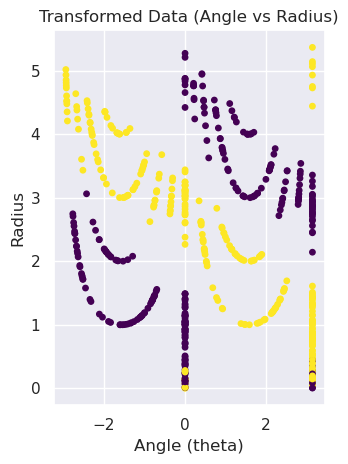

In [9]:
plt.subplot(1, 2, 2)
plt.title("Transformed Data (Angle vs Radius)")
# We use the engineered features for this plot
plt.scatter(inputs["angle"], inputs["radius"], c=targets, cmap='viridis', s=15)
plt.xlabel("Angle (theta)")
plt.ylabel("Radius")
plt.tight_layout()
plt.show()

### Feature importance

In [10]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(inputs, targets)

accuracies = cross_val_score(rfc_model, inputs, targets, cv=10, scoring="accuracy")
accuracies.mean()

0.9516666666666665

In [11]:
feature_importances = rfc_model.feature_importances_

importances = pd.DataFrame(
    zip(inputs.columns.to_list(), feature_importances),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

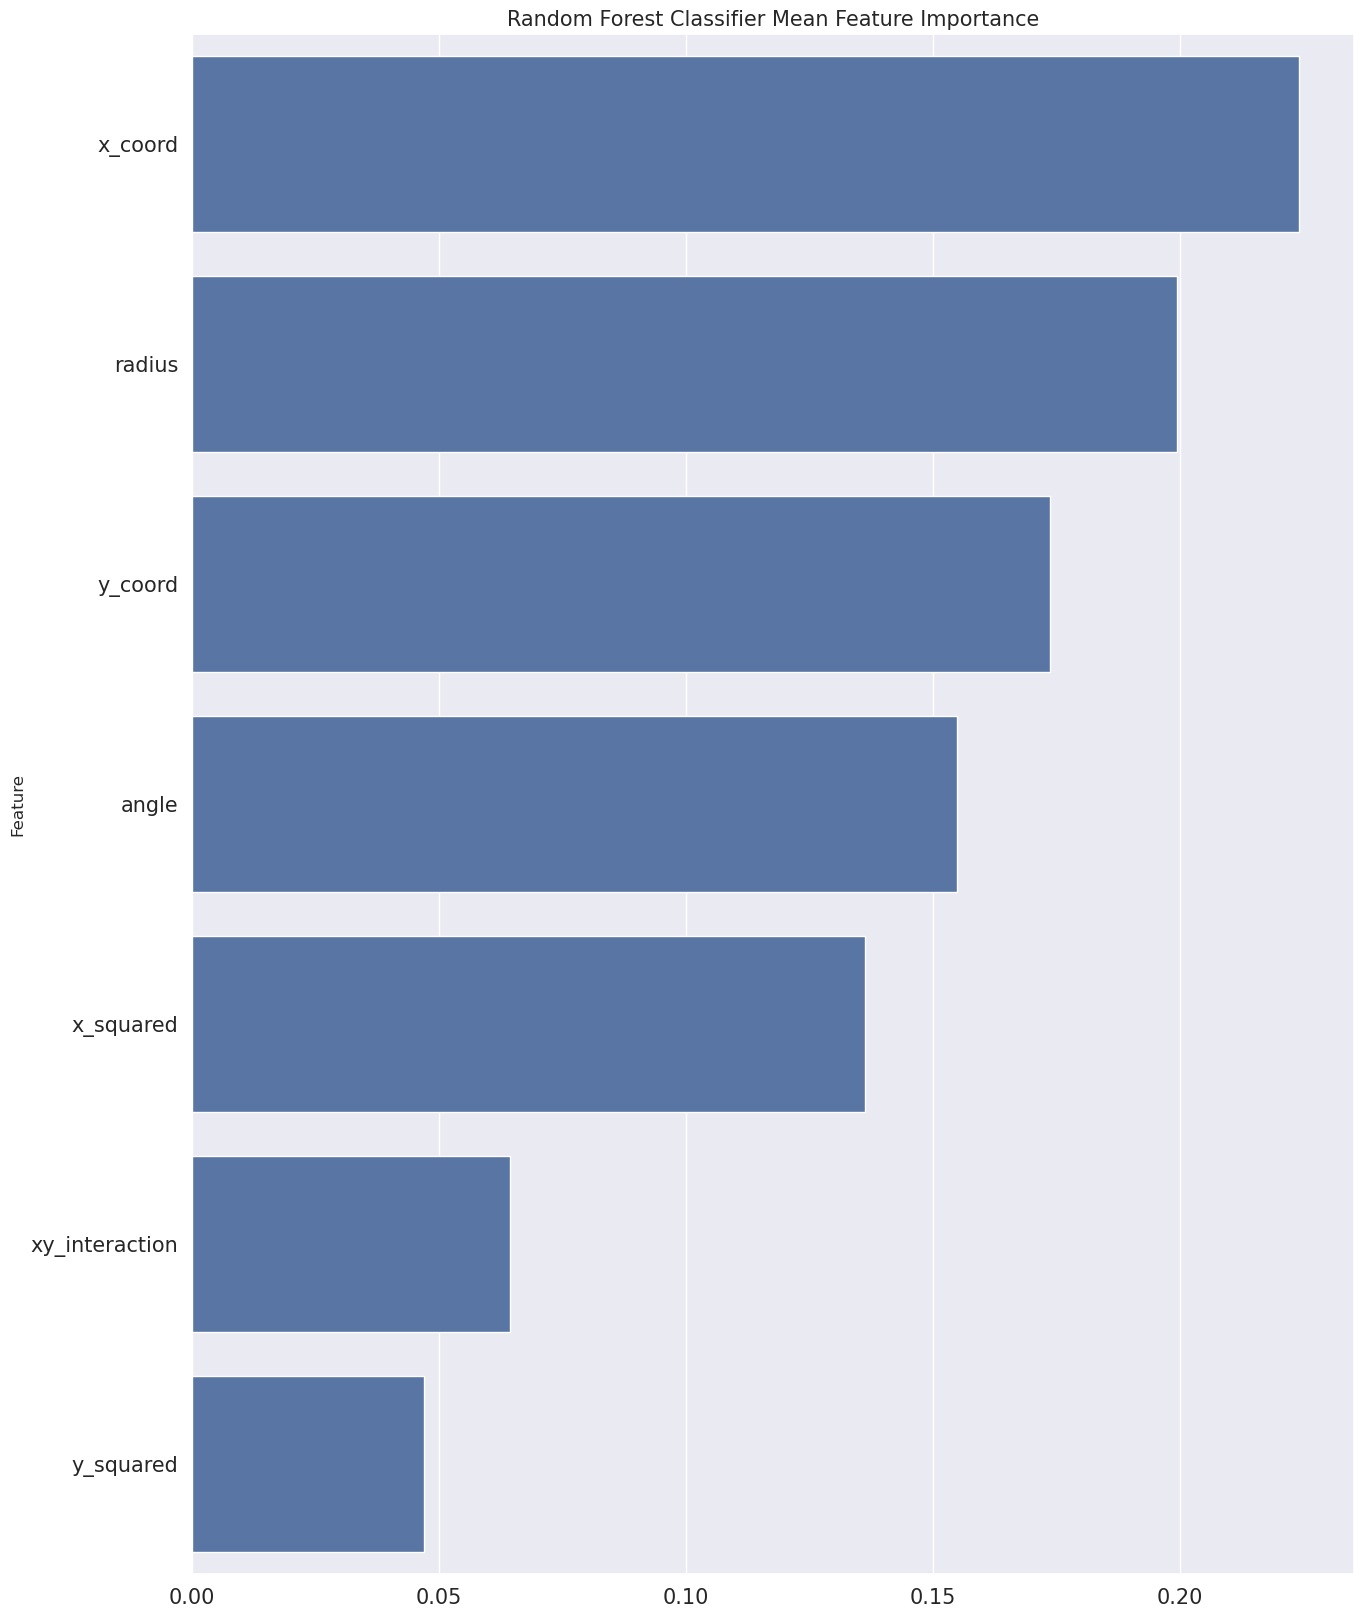

In [12]:
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance', size=15)

plt.show()

In [13]:
inputs = inputs.drop(["x_squared", "y_squared", "xy_interaction"], axis=1)

In [14]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(inputs, targets)

accuracies = cross_val_score(rfc_model, inputs, targets, cv=10, scoring="accuracy")
accuracies.mean()

0.9533333333333331

### Normalize input

In [15]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [16]:
norm_inputs = normalize_input(inputs)

In [17]:
norm_inputs.min()

x_coord    0.0
y_coord    0.0
radius     0.0
angle      0.0
dtype: float64

In [18]:
norm_inputs.max()

x_coord    1.0
y_coord    1.0
radius     1.0
angle      1.0
dtype: float64

### Numpy

In [19]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.55700538, 0.375     , 0.21333289, 0.30921432],
       [0.49182309, 0.75      , 0.37321138, 0.75273615],
       [0.25123234, 0.125     , 0.75101768, 0.10495248],
       [0.61538661, 0.5       , 0.21993016, 0.48351575],
       [0.21738698, 0.5       , 0.56893286, 1.        ]])

In [20]:
inputs.shape

(600, 4)

In [21]:
n_inputs = inputs.shape[1]

In [22]:
targets = targets.to_numpy()
targets[:5]

array([0, 1, 1, 0, 0])

### Train vs. Test set

In [23]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

### Hyperparameter tuning

In [24]:
# Grid Search

hp_grid = {
    "learning_rate": [5e-3, 1e-3, 5e-4],
    "batch_size": [2, 4, 8],
    "hidden_layers": [2],
    "hidden_neurons": [4]
}

def train_and_evaluate(hp_config):
    inputs, target, _, loss = build_classification_model(n_inputs, hp_config["hidden_layers"], hp_config["hidden_neurons"])
    train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, hp_config["batch_size"], hp_config["learning_rate"], inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA, log=False)
    average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)
    return average_loss

best_hp_config = start_hp_search(hp_grid, train_and_evaluate)

Search iteration: 1
Testing config: {'learning_rate': 0.005, 'batch_size': 2, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.6218868697783991
Search iteration: 2
Testing config: {'learning_rate': 0.005, 'batch_size': 4, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.5241450242763549
Search iteration: 3
Testing config: {'learning_rate': 0.005, 'batch_size': 8, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.35279257380546825
Search iteration: 4
Testing config: {'learning_rate': 0.001, 'batch_size': 2, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.26943808002216296
Search iteration: 5
Testing config: {'learning_rate': 0.001, 'batch_size': 4, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.6928423332457945
Search iteration: 6
Testing config: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.6664008729250501
Search iteration: 7
Testing config: {'learning_rate': 0.0005, 'batch_size': 2, 'hidden_layers': 2, 'hidden_neurons': 4}
Loss: 0.614188

In [25]:
batch_size = best_hp_config["batch_size"]
print(f"Best batch size: {batch_size}")

learning_rate = best_hp_config["learning_rate"]
print(f"Best learning rate: {learning_rate}")

hidden_layers = best_hp_config["hidden_layers"]
print(f"Best number of hidden layers: {hidden_layers}")

hidden_neurons = best_hp_config["hidden_neurons"]
print(f"Best number of neurons in hidden layer: {hidden_neurons}")

Best batch size: 2
Best learning rate: 0.001
Best number of hidden layers: 2
Best number of neurons in hidden layer: 4


### Training

In [32]:
inputs, target, output, loss = build_classification_model(n_inputs, hidden_layers, hidden_neurons)

history = train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, batch_size, learning_rate, inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA)

Epoch 0: loss=1.367114886150087, test_loss=inf
Epoch 1: loss=0.93983028969392, test_loss=1.1435646187711506
Epoch 2: loss=0.821379154907938, test_loss=0.8831200561096659
Epoch 3: loss=0.7805975081413742, test_loss=0.8240874000236198
Epoch 4: loss=0.7613110449957345, test_loss=0.7873759640683673
Epoch 5: loss=0.7450074208119261, test_loss=0.7679502561718008
Epoch 6: loss=0.7290887040121886, test_loss=0.7502755438658109
Epoch 7: loss=0.7120576437512464, test_loss=0.7331922985658091
Epoch 8: loss=0.7000611472391545, test_loss=0.7194595784660033
Epoch 9: loss=0.6894941408110331, test_loss=0.706988141313324
Epoch 10: loss=0.6816437609829819, test_loss=0.6963297078585023
Epoch 11: loss=0.6730807081466255, test_loss=0.6882966322326787
Epoch 12: loss=0.668359843122077, test_loss=0.6844380435359712
Epoch 13: loss=0.6633746180355259, test_loss=0.6806860757245937
Epoch 14: loss=0.6600985730069142, test_loss=0.6775335436341733
Epoch 15: loss=0.6569527102757259, test_loss=0.6774230603659304
Epoch 1

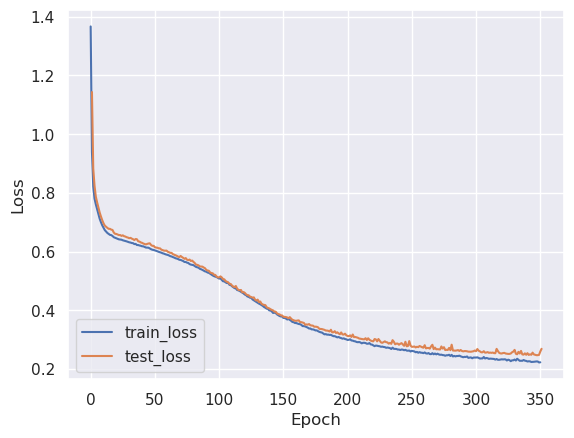

In [33]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")

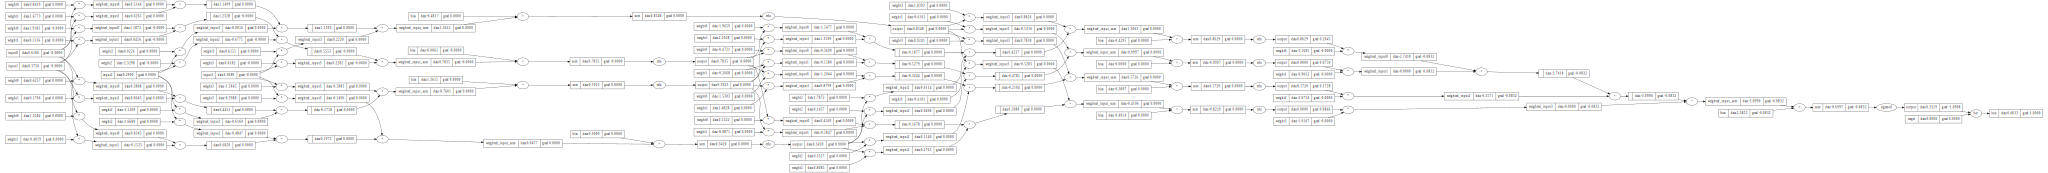

In [34]:
draw_dot(loss)

## Test solution

In [35]:
average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)
average_loss

0.24697759612265455

In [ ]:
misses = 0
test_data_size = len(inputs_test)
for sample_index in range(test_data_size):
    for input_index, input in enumerate(inputs):
        input.data = inputs_test[sample_index][input_index]
    target.data = targets_test[sample_index]
    loss_value = loss.forward()
    prediction = int(output.data > 0.5)
    misses += np.abs(prediction - target.data)

print(f"Test set Accuracy: {(test_data_size - misses) / test_data_size * 100}%")


Test set Accuracy: 93.33333333333333%
